# Get features

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
import pickle
from scipy.ndimage.measurements import label

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
cars = glob.glob("vehicles/*/*.png")
non_cars = glob.glob("non-vehicles/*/*.png")
# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Read X Vector
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [59]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localize.h5")



Using TensorFlow backend.


Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 48s - loss: 0.5241 - acc: 0.4648 - val_loss: 0.1872 - val_acc: 0.8328

In [61]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")

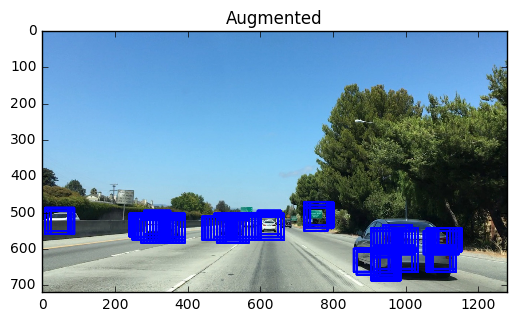

In [69]:
%matplotlib inline
import matplotlib.pylab as plt
data = (skimage.io.imread('examples/bbox-example-image.jpg'))

def locate(data):
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    '''
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()
    '''
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def draw_hot_final(img, window_img, hot_windows):
    # Read in image similar to one shown above 
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

annotated = locate(data)

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

In [70]:
def process_image(img):
    data = (img)
    heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")
    result = locate(data)
    return result

In [71]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [82]:
output_project = 'project_video_dp.mp4'
clip3 = VideoFileClip("project_video.mp4")
project_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output_project, audio=False)

/home/ubuntu/anaconda3/envs/udacitypython3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_dp.mp4
----------------------------------------

Writing video into project_video_dp.mp4
                                                                            Done writing video in project_video_dp.mp4 !
Your video is ready !
CPU times: user 6h 35min 38s, sys: 9min 37s, total: 6h 45min 15s
Wall time: 6h 42min 46s


In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project))